# Bootstrap validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Validate the bootstrap outcomes

Check the mean of the bootstrap distributions for mean, variance, and correlation.

In [400]:
true_data = simulate.simulate_transcriptomes(10000, 500, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, .1, 0.011)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [ ]:
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors, verbose=False, Nr=Nr)
var_scdd = scdd.M_to_var(M_dd)
num_boot = 100


In [83]:
%%time
#Real bootstrap
real_boot_vars = []
data_first_gene = adata.X[:, [0]].toarray()
for trial in range(num_boot):
    
    boot_idxs = np.random.choice(adata.shape[0], adata.shape[0], replace=True)
    mean, var = estimator._poisson_1d(sp.sparse.csc_matrix(data_first_gene[boot_idxs]), adata.shape[0], size_factor=size_factors[boot_idxs], n_umi=Nr)
    
    real_boot_vars.append(var[0])

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


In [401]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)
scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True)
scmemo.compute_2d_moments(adata_scmemo, inplace=True, gene_1=adata_scmemo.var.index[[0, 2]], gene_2=adata_scmemo.var.index[[1, 3]])

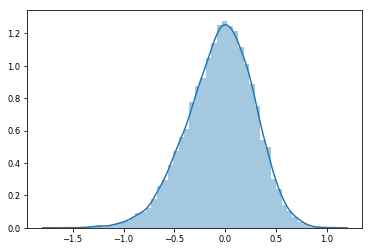

In [507]:
sns.distplot(np.log(adata_scmemo.uns['scmemo']['all_size_factor']))

In [402]:
adata_scmemo.uns['scmemo']['1d_moments']['sg^PBMC'][1][:5]

array([9.63754843e-08, 1.39221442e-07, 1.99869645e-06, 1.22267119e-06,
       7.09326132e-08])

In [403]:
adata_scmemo.uns['scmemo']['2d_moments']['sg^PBMC'][1]

array([[-0.0231803 ,  0.02803398],
       [-0.00346433,  0.01462064]])

In [508]:
%%time
df = pd.DataFrame(
    data=np.vstack([
        adata_scmemo.uns['scmemo']['all_size_factor'], 
        1/adata_scmemo.uns['scmemo']['all_size_factor'], 
        1/adata_scmemo.uns['scmemo']['all_size_factor']**2]).T,
    columns=['size_factor', 'inv_size_factor', 'inv_size_factor_sq'])
df['expr'] = adata_scmemo.X[:, 0].toarray().reshape(-1)
df['bin_cutoff'] = 1.0
df['bin'] = True

CPU times: user 5.51 ms, sys: 0 ns, total: 5.51 ms
Wall time: 4.66 ms


In [526]:
from sklearn.neighbors import KernelDensity

In [615]:
x = np.log(df.query('expr == 2')['size_factor']).values.reshape(-1,1)
print(x.shape)

(219, 1)


In [616]:
%%time
kde_2 = stats.gaussian_kde(x.reshape(-1))
samples_2 = kde_2.resample(10000)

CPU times: user 2.32 ms, sys: 130 µs, total: 2.45 ms
Wall time: 1.9 ms


In [617]:
%%time
kde = KernelDensity(bandwidth=0.1)
kde.fit(x)
samples = kde.sample(n_samples=10000)

CPU times: user 1.51 ms, sys: 85 µs, total: 1.6 ms
Wall time: 1.13 ms


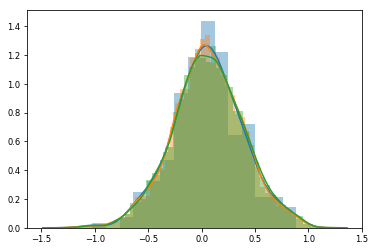

In [618]:
sns.distplot(x.reshape(-1))
sns.distplot(samples)
sns.distplot(samples_2)

In [528]:
np.log(df.query('expr == 0')['inv_size_factor_sq']).shape

(8775,)

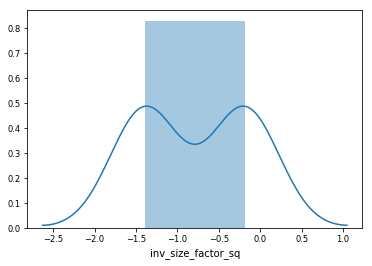

In [525]:
sns.distplot(np.log(df.query('expr == 7')['inv_size_factor_sq']))

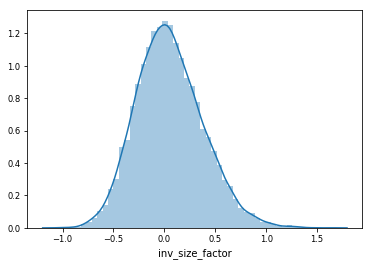

In [513]:
sns.distplot(np.log(df['inv_size_factor']))

In [482]:
csc_mat = adata_scmemo.X.tocsc()

In [495]:
%%time
imp.reload(bootstrap)
mean, var = bootstrap._bootstrap_1d(csc_mat[:, 0],  sf_df=df, n_umi=adata_scmemo.uns['scmemo']['n_umi'], num_boot=10000, bins=10, dirichlet_approx=True)
# print(var.mean())

CPU times: user 37.5 ms, sys: 62 µs, total: 37.6 ms
Wall time: 36.8 ms


In [504]:
%%time
a = np.random.randint(2, size=100000)

CPU times: user 923 µs, sys: 38 µs, total: 961 µs
Wall time: 483 µs


In [505]:
%%time
np.random.shuffle(a)

CPU times: user 1.89 ms, sys: 0 ns, total: 1.89 ms
Wall time: 1.89 ms


In [ ]:
for i in range(df.shape[0])

In [474]:
import string

In [477]:

df.groupby('expr')['size_factor'].transform(lambda x: pd.cut(x, bins=0, labels=list(string.ascii_lowercase[:0])))

ValueError: `bins` should be a positive integer.

In [430]:
%%time
a = df.groupby('expr')['size_factor'].size()

CPU times: user 1.96 ms, sys: 82 µs, total: 2.04 ms
Wall time: 1.33 ms


In [451]:
%%time
a = df.groupby('expr')['size_factor'].apply(list).to_dict()

CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3.19 ms


In [452]:
%%time
a = np.random.choice(a[0], len(a[0])).mean()

CPU times: user 1.35 ms, sys: 57 µs, total: 1.41 ms
Wall time: 831 µs


In [434]:
gene_rvs = stats.multinomial.rvs(n=100, p=[.7, .2, .1], size=1000).T

In [435]:
gene_rvs

array([[71, 75, 71, ..., 67, 70, 80],
       [20, 22, 15, ..., 19, 22, 13],
       [ 9,  3, 14, ..., 14,  8,  7]])

In [415]:
%lprun -f bootstrap._bootstrap_1d bootstrap._bootstrap_1d(csc_mat[:, 0],  sf_df=df, n_umi=adata_scmemo.uns['scmemo']['n_umi'], num_boot=10000, bins=2, dirichlet_approx=True)

Timer unit: 1e-06 s

Total time: 0.019511 s
File: /home/ssm-user/Github/scrna-parameter-estimation/scmemo/bootstrap.py
Function: _bootstrap_1d at line 75

Line #      Hits         Time  Per Hit   % Time  Line Contents
    75                                           def _bootstrap_1d(
    76                                           	data, 
    77                                           	sf_df, 
    78                                           	num_boot=1000, 
    79                                           	mv_regressor=None, 
    80                                           	n_umi=1, 
    81                                           	bins=2, 
    82                                           	dirichlet_approx=True,
    83                                           	log=True):
    84                                           	"""
    85                                           		Perform the bootstrap and CI calculation for mean and variance.
    86                                   

In [414]:
%lprun -f bootstrap._bootstrap_1d bootstrap._bootstrap_1d(csc_mat[:, 0],  sf_df=df, n_umi=adata_scmemo.uns['scmemo']['n_umi'], num_boot=10000, bins=10, dirichlet_approx=True)

Timer unit: 1e-06 s

Total time: 0.077346 s
File: /home/ssm-user/Github/scrna-parameter-estimation/scmemo/bootstrap.py
Function: _bootstrap_1d at line 75

Line #      Hits         Time  Per Hit   % Time  Line Contents
    75                                           def _bootstrap_1d(
    76                                           	data, 
    77                                           	sf_df, 
    78                                           	num_boot=1000, 
    79                                           	mv_regressor=None, 
    80                                           	n_umi=1, 
    81                                           	bins=2, 
    82                                           	dirichlet_approx=True,
    83                                           	log=True):
    84                                           	"""
    85                                           		Perform the bootstrap and CI calculation for mean and variance.
    86                                   

In [386]:
imp.reload(bootstrap)

<module 'bootstrap' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/bootstrap.py'>

In [413]:
%%time
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
mean, var= bootstrap._bootstrap_1d(
    csc_mat[:, 0], 
    sf_df=df, 
    n_umi=adata_scmemo.uns['scmemo']['n_umi'],
    num_boot=10000,
    bins=2,
    dirichlet_approx=True)
print(var.mean())

-16.158789192595407
CPU times: user 14.5 ms, sys: 0 ns, total: 14.5 ms
Wall time: 13.7 ms


In [397]:
%%time
# imp.reload(bootstrap)
cov, corr, var_1, var_2 = bootstrap._bootstrap_2d(
    csc_mat[:, [0, 1]], 
    sf_df=df, 
    n_umi=adata_scmemo.uns['scmemo']['n_umi'],
    num_boot=10000,
    bins=2)
print(var_1.mean(), var_2.mean())
print(cov.mean(), corr.mean())

9.398783822804087e-08 2.2915542493337632e-09
-1.0241019602300748e-11 -0.0006960628630312668
CPU times: user 165 ms, sys: 58 µs, total: 165 ms
Wall time: 164 ms


### Characterize the approximate bootstrap

In [463]:
from statsmodels.distributions.empirical_distribution import ECDF

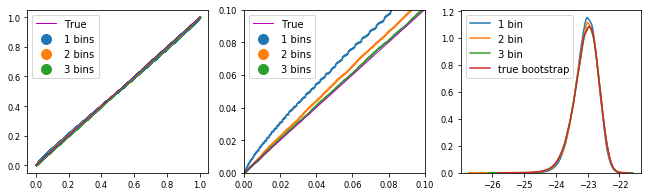

In [489]:
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 2)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.xlim(0, .1); plt.ylim(0, .1)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 3)
sns.distplot(np.log(res_1[1]), hist=False, label='1 bin')
sns.distplot(np.log(res_2[1]), hist=False, label='2 bin')
sns.distplot(np.log(res_3[1]), hist=False, label='3 bin')
sns.distplot(np.log(real_boot_vars), hist=False, label='true bootstrap')
